In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

## 1


#### 1.1 

In [2]:
def lin0(x):
    return x + 4

def lin1(x):
    return x

def lin2(x):
    return 2*x - 1

def lin3(x):
    return -3*x - 4

def lin4(x):
    return -5*x + 20

x = np.linspace(-5, 5, 1000)
ylc = np.piecewise(x, [x<-2, (x>=-2)*(x<-1), (x>=-1)*(x<=1), (x>=1)*(x<3), x>=3], [lin0, lin3, lin1, lin2, lin4])

def dis0(x):
    return x

def dis1(x):
    return 2*x + 2

def dis2(x):
    return 3*x - 10

def dis3(x):
    return -x

def dis4(x):
    return 2

yldc = np.piecewise(x, [x<-2, (x>=-2)*(x<-1), (x>=-1)*(x<=1), (x>=1)*(x<3), x>=3], [dis0, dis1, dis2, dis3, dis4])

def q1(x):
    return x*x
def q2(x):
    return -2*x*x - 12*x - 12
def q3(x):
    return -2*x*x + 12*x - 12

yq = np.piecewise(x, [x<-2, (x>=-2)*(x<2), x>=2], [q2, q1, q3])

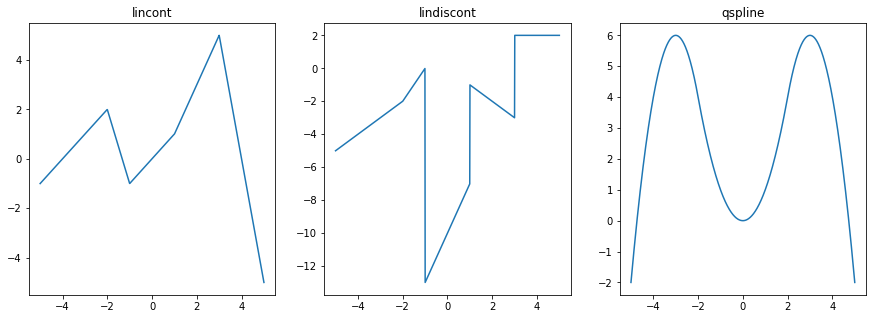

In [3]:
sigs = np.array([ylc, yldc, yq])
names = ['lincont', 'lindiscont', 'qspline']

plt.figure(figsize=(15, 5))
for i, sig, name in zip([1, 2, 3], sigs, names):
    ax = plt.subplot(1, 3, i)
    ax.plot(x, sig)
    plt.title(name)

#### 1.2

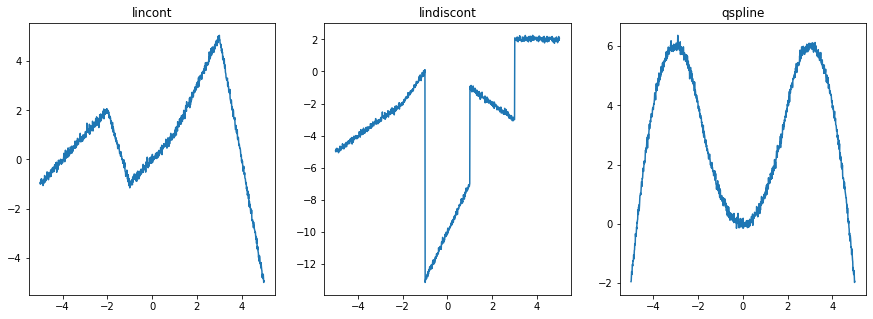

In [4]:
np.random.seed(42)

noise = 0.1*np.random.randn(1000)
signs = sigs + noise

plt.figure(figsize=(15, 5))
for i, sig, name in zip([1, 2, 3], signs, names):
    ax = plt.subplot(1, 3, i)
    ax.plot(x, sig)
    plt.title(name)

#### 1.3

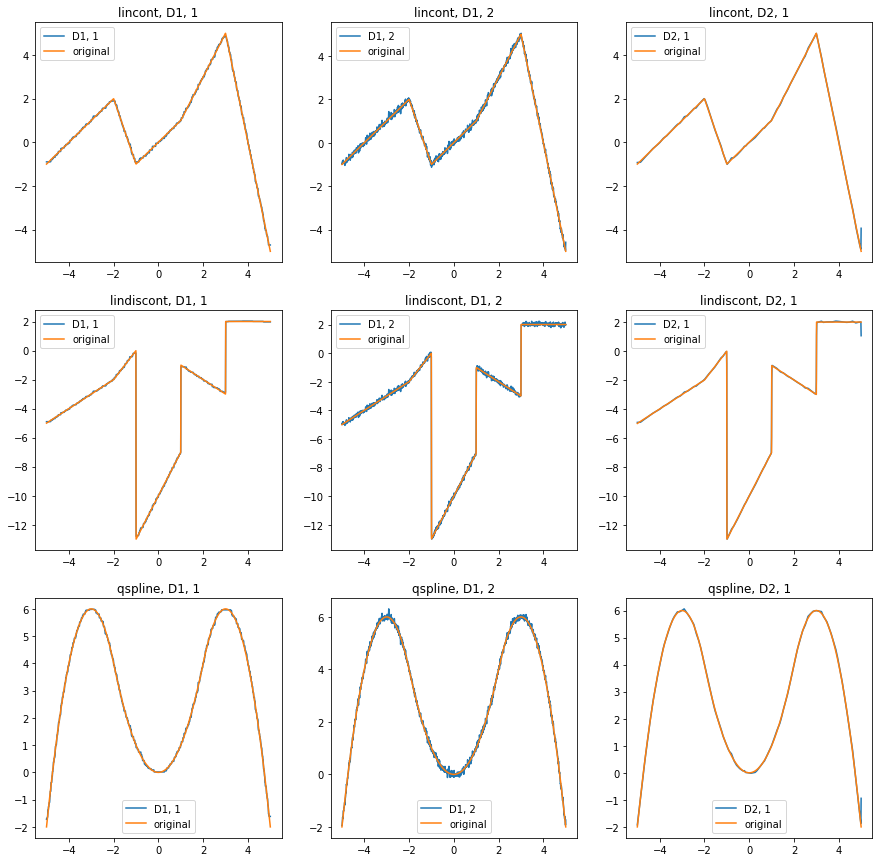

In [5]:
import cvxpy as cp
from scipy.sparse import diags

D1 = diags([1, -1], [0, 1], shape=(1000, 1000)).toarray()
D2 = diags([1, -2, 1], [0, 1, 2], shape=(1000, 1000)).toarray()

penalties = [('D1', D1, 1), ('D1', D1, 2), ('D2', D2, 1)]

def filter_signal(y, D, n, gamma=1):
    x = cp.Variable(1000)
    objective = cp.Minimize(cp.sum_squares(y-x) +
                      gamma*cp.norm(D*x, n))
    prob = cp.Problem(objective)
    prob.solve()
    
    return x.value

x = np.linspace(-5, 5, 1000)
plt.figure(figsize=(15, 15))
for i, name, sig, sign in zip([0, 1, 2], names, sigs, signs):
    j = 1
    for Dname, D, n in penalties:
        ax = plt.subplot(3, 3, 3*i + j)
        yfilt = filter_signal(sign, D, n)
        ax.plot(x, yfilt, label=f'{Dname}, {n}')
        ax.plot(x, sig, label='original')
        j += 1
        plt.title(f'{name}, {Dname}, {n}')
        plt.legend()
    

#### 1.4

Note: there must be an error in the problem description: it makes no sense to plot $||y - x||_2$ vs $||D\hat x||$ as neither $y$ nor $x$ does not depend on gamma. I decided to plot $||\hat x - x||_2$ vs $||D\hat x||$, the squared error of the prediction vs penalty.

Optimal gamma for each case is in the title of the plot.

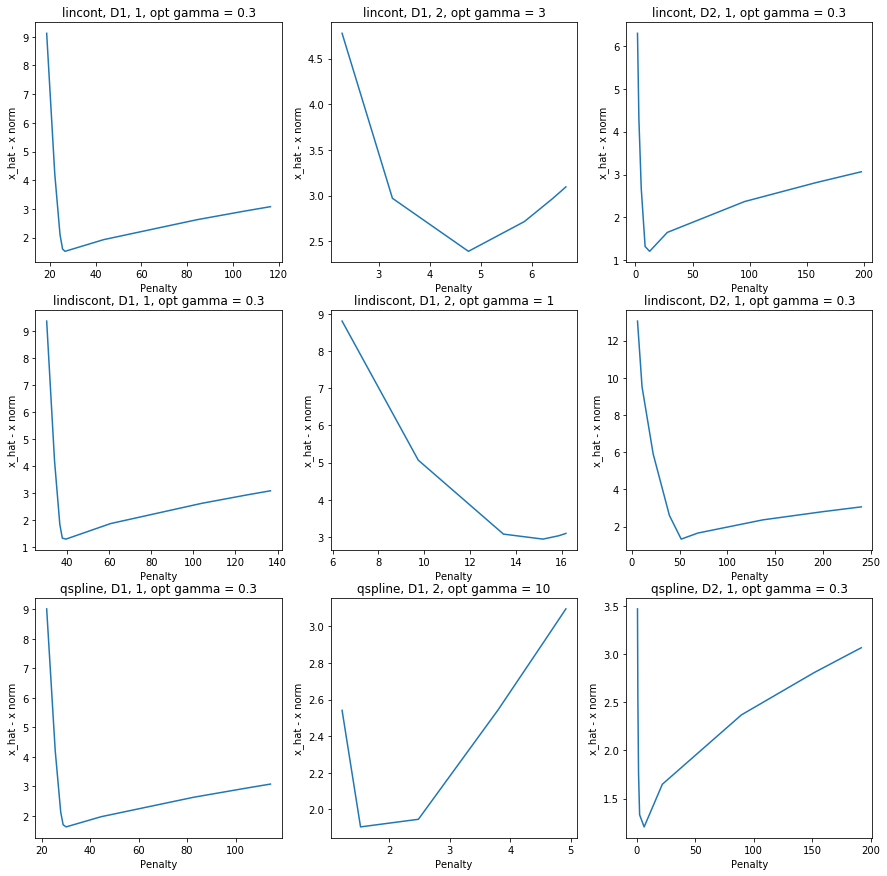

In [6]:
gammas = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]
plt.figure(figsize=(15, 15))
for i, name, sig, sign in zip([0, 1, 2], names, sigs, signs):
    j = 1
    for Dname, D, n in penalties:
        ax = plt.subplot(3, 3, 3*i + j)
        Dxnorms = []
        xxhatnorms = []
        for g in gammas:
            yfilt = filter_signal(sign, D, n, gamma=g)
            Dxnorms.append(np.linalg.norm(D@yfilt, n))
            xxhatnorms.append(np.linalg.norm(sig-yfilt, 2))
        gmin = gammas[np.argmin(xxhatnorms)]
        ax.plot(Dxnorms, xxhatnorms)
        plt.xlabel(f'Penalty')
        plt.ylabel('x_hat - x norm')
        j += 1
        plt.title(f'{name}, {Dname}, {n}, opt gamma = {gmin}')

## 2
* $(a-c)^T P^{-1}(a-c) \le 1$
* $1 - (a-c)^T P^{-1}(a-c) \ge 0$
* $P^{-1} \succ 0$ ($ \ \mathcal{E} \ $ is an ellipsoid) $\rightarrow
\begin{bmatrix}
P & a - c \\
(a - c)^T & 1 \end{bmatrix} \succ 0$
* Can be rewritten as $A_0 + a_1 A_1 + ... + a_n A_n \succ 0$ where $A_i, i = 1, ... n$ has all zero elements except $A_i [i, n]$ and $A_i [n, i]$ which are equal to $1$ and $A_0$ is as follows: 
$$
A_0 = 
\begin{bmatrix}
P &  - c \\
- c^T & 1 \end{bmatrix}
$$


## 3

#### 3.1

In [28]:
np.random.seed(1)

In [35]:
A = np.random.randint(3, size=(20, 20))  # generate a random adjacency matrix
A = A + A.T  # make it symmetric
A = np.where(A==0, 0, 1)
L = np.diag(np.sum(A, axis=0)) - A # laplacian

values_rand = []
for i in range(1000):
    x = np.random.randint(2, size=20)
    x = np.where(x==1, 1, -1)
    values_rand.append(x.T @ L @ x)

Text(0, 0.5, 'function value')

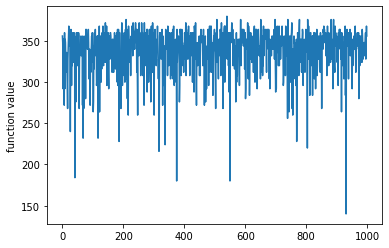

In [36]:
plt.plot(values_rand)
plt.ylabel('function value')

#### 3.2

In [37]:
import cvxpy as cp

x = cp.Variable((20, 20), PSD=True)
objective = cp.Maximize(cp.trace(L@x))
constraints = [x >> 0]
constraints += [cp.diag(x) == 1.]
prob = cp.Problem(objective, constraints)
result = prob.solve(solver=cp.CVXOPT)
opt_val_sdp = prob.value

Text(0, 0.5, 'sdp value')

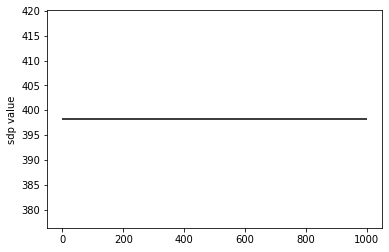

In [38]:
plt.hlines(opt_val_sdp, 0, 1000)
plt.ylabel('sdp value')

#### 3.3

In [39]:
r = np.linalg.cholesky(x.value)
values_gw = []
for i in range(1000):
    ksi = np.random.randint(2, size=20)
    rr = r @ ksi
    rr = np.where(rr>0, 1, -1)
    values_gw.append(rr.T @ L @ rr)
    

Text(0, 0.5, 'function value')

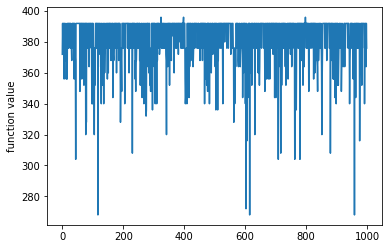

In [40]:
plt.plot(values_gw)
plt.ylabel('function value')

#### 3.4

Text(0, 0.5, 'mean gw')

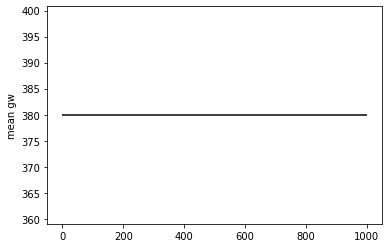

In [41]:
plt.hlines(np.mean(values_gw), 0, 1000)
plt.ylabel('mean gw')

Combining all results on one plot:

Text(0, 0.5, 'function value')

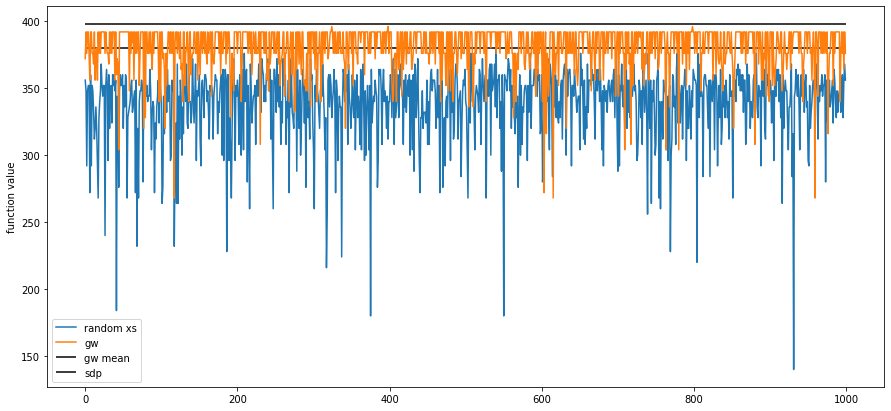

In [44]:
plt.figure(figsize=(15, 7))
plt.plot(values_rand, label='random xs')
plt.plot(values_gw, label='gw')
plt.hlines(np.mean(values_gw), 0, 1000, label='gw mean')
plt.hlines(opt_val_sdp, 0, 1000, label='sdp')
plt.legend()
plt.ylabel('function value')

## 4

#### 4.1

* Our scope is to maximize the profit for the flight
* The target is as follows ($x_{ij}$ is $i$th cargo in the $j$th compartment): 
$$
\max 310[x_{11}+ x_{12}+x_{13}] + 380[x_{21}+ x_{22}+x_{23}] + 350[x_{31}+ x_{32}+x_{33}] + 285[x_{41}+ x_{42}+x_{43}]
$$
* We have the following constraints:
* Weight in each compartment: $\sum_{i=1}^4 x_{i1} \le 10, \ \sum_{i=1}^4 x_{i2} \le 16, \ \sum_{i=1}^4 x_{i3} \le 8$ 
* Volume in each compartment: $480x_{11} + 650x_{21} + 580x_{31} + 390x_{41} \le 6800, \ 480x_{12} + 650x_{22} + 580x_{32} + 390x_{42} \le 8700, \ 480x_{13} + 650x_{23} + 580x_{33} + 390x_{43} \leq 5300$
* Equal distribution of weights: $\frac{\sum_{i=1}^4 x_{i1}}{10} = \frac{\sum_{i=1}^4 x_{i2}}{16} = \frac{\sum_{i=1}^4 x_{i3}}{8}$

#### 4.2
* Our assumption is that $x_{ij}$ can be any real number greater than zero i.e. that the cargo comes in, say, powder, not some little boxes which have minimal weight which we wouldn't be able to divide any further.

#### 4.3

In [54]:
from  scipy.optimize import linprog

c = np.array([-310, -310, -310, -380, -380, -380, -350, -350, -350, -285, -285, -285])  # prices (x is flattened)

# inequality constraints
A_ub = np.array([[1,1,1,1,0,0,0,0,0,0,0,0], 
                 [0,0,0,0,1,1,1,1,0,0,0,0],
                 [0,0,0,0,0,0,0,0,1,1,1,1],
                 [480,650,580,390,0,0,0,0,0,0,0,0,],
                 [0,0,0,0,480,650,580,390,0,0,0,0,],
                 [0,0,0,0,0,0,0,0,480,650,580,390],
                 [1,0,0,0,1,0,0,0,1,0,0,0],
                 [0,1,0,0,0,1,0,0,0,1,0,0],
                 [0,0,1,0,0,0,1,0,0,0,1,0],
                 [0,0,0,1,0,0,0,1,0,0,0,1]])
b_ub = np.array([10, 16, 8, 6800, 8700, 5300, 18, 15, 23, 12])

# equality constraints
A_eq= [[0.1, -0.0625, 0, 0.1, -0.0625, 0, 0.1, -0.0625, 0, 0.1, -0.0625, 0],
     [0.1, 0, -0.125, 0.1, 0, -0.125, 0.1, 0, -0.125, 0.1, 0, -0.125],
    [0, 0.0625, -0.125, 0, 0.0625, -0.125, 0, 0.0625, -0.125, 0, 0.0625, -0.125]]

b_eq = [0, 0, 0]

res = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq)
f0 = -res.fun

In [51]:
print(f'Total profit {-res.fun}')

Total profit 12489.999862573459


#### 4.4

In [55]:
b_ub_1 = np.array([10, 16, 8, 6800, 8700, 5300, 18, 15, 23, 12])
b_ub_1[-1] += 1.2
print(f'Profit change, 4th cargo +10%: {f0 + linprog(c, A_ub=A_ub, b_ub=b_ub_1, A_eq=A_eq, b_eq=b_eq).fun}')
b_ub_1[-1] -= 2.4
print(f'Profit change, 4th cargo -10%: {f0 + linprog(c, A_ub=A_ub, b_ub=b_ub_1, A_eq=A_eq, b_eq=b_eq).fun}')

Profit change, 4th cargo +10%: -2.50013737847803
Profit change, 4th cargo -10%: 4.999862634107558


In [57]:
b_ub_1 = np.array([10, 16, 8, 6800, 8700, 5300, 18, 15, 23, 12])
b_ub_1[-2] += 2.3
print(f'Profit change, 3th cargo +10%: {f0 + linprog(c, A_ub=A_ub, b_ub=b_ub_1, A_eq=A_eq, b_eq=b_eq).fun}')
b_ub_1[-2] -= 4.6
print(f'Profit change, 3th cargo -10%: {f0 + linprog(c, A_ub=A_ub, b_ub=b_ub_1, A_eq=A_eq, b_eq=b_eq).fun}')

Profit change, 3th cargo +10%: -7.732393714832142e-05
Profit change, 3th cargo -10%: -6.631642463617027e-06


In [58]:
b_ub_1 = np.array([10, 16, 8, 6800, 8700, 5300, 18, 15, 23, 12])
b_ub_1[-3] += 1.5
print(f'Profit change, 2nd cargo +10%: {f0 + linprog(c, A_ub=A_ub, b_ub=b_ub_1, A_eq=A_eq, b_eq=b_eq).fun}')
b_ub_1[-3] -= 3.0
print(f'Profit change, 2nd cargo -10%: {f0 + linprog(c, A_ub=A_ub, b_ub=b_ub_1, A_eq=A_eq, b_eq=b_eq).fun}')

Profit change, 2nd cargo +10%: -8.00960224296432e-05
Profit change, 2nd cargo -10%: -4.008411451650318e-05


In [59]:
b_ub_1 = np.array([10, 16, 8, 6800, 8700, 5300, 18, 15, 23, 12])
b_ub_1[-1] += 1.8
print(f'Profit change, 1st cargo +10%: {f0 + linprog(c, A_ub=A_ub, b_ub=b_ub_1, A_eq=A_eq, b_eq=b_eq).fun}')
b_ub_1[-1] -= 3.6
print(f'Profit change, 1st cargo -10%: {f0 + linprog(c, A_ub=A_ub, b_ub=b_ub_1, A_eq=A_eq, b_eq=b_eq).fun}')

Profit change, 1st cargo +10%: -2.50013737847803
Profit change, 1st cargo -10%: 72.49989888106938


1st and 4th cargos influence profit the most.